# Load current data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!ls data/train/

ls: cannot access 'data/train/': No such file or directory


In [2]:
# TRAIN = [f"data/train/train_image_data_{i}.parquet" for i in range(4)]
TRAIN = [f"../data2/train_image_data_{i}.feather" for i in range(4)]

In [5]:
train_0 = pd.read_feather(TRAIN[0])

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


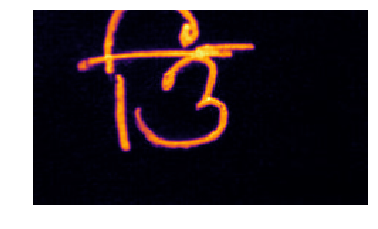

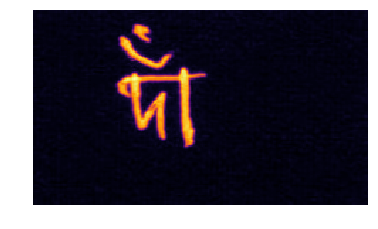

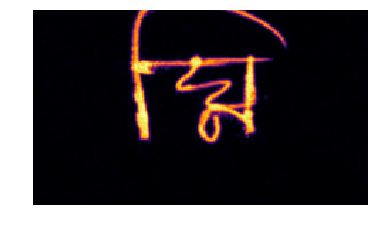

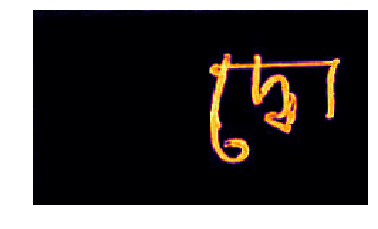

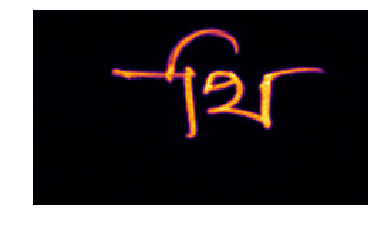

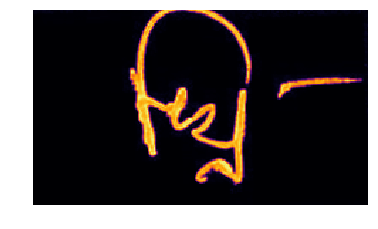

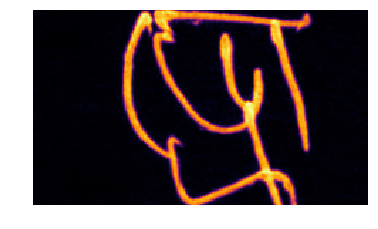

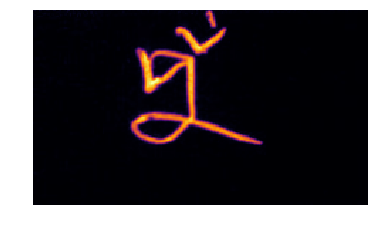

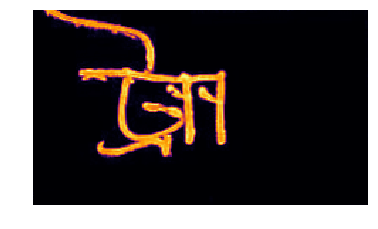

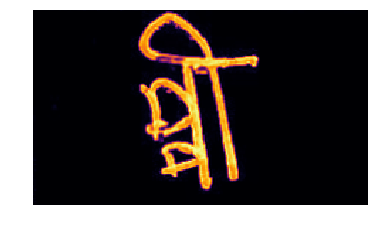

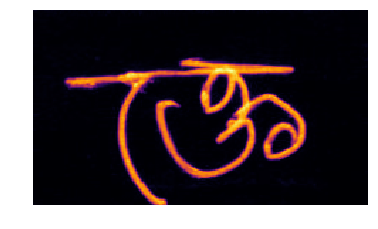

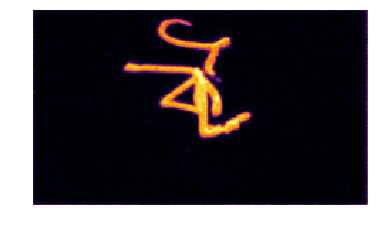

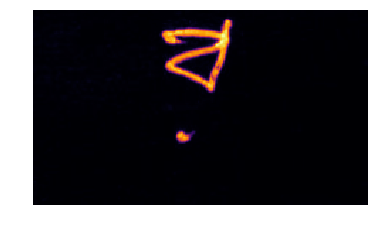

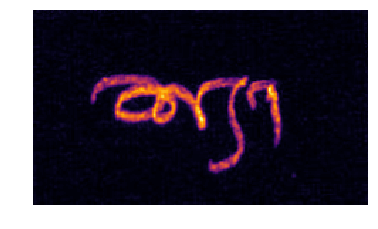

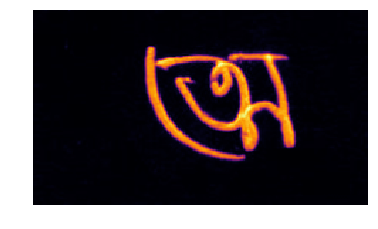

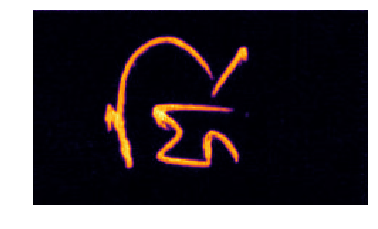

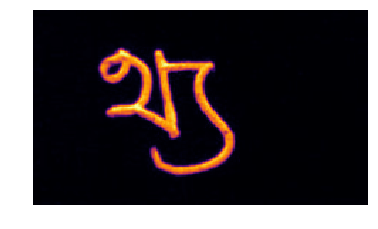

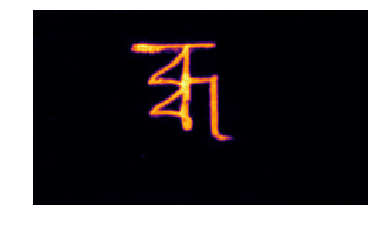

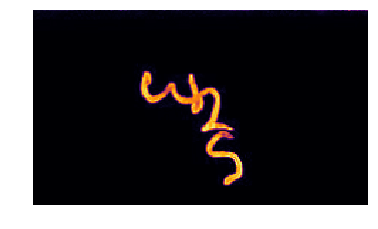

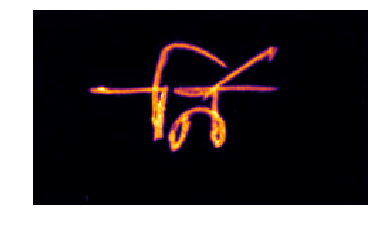

(137, 236)

In [6]:
L, H = 100, 120
for i in range(L, H):
    img = train_0.iloc[i].values[1:].reshape(137, -1).astype('float')
    plt.imshow(img, cmap='inferno_r')
    plt.axis('off')
    plt.show()
img.shape

Need to convert these images so that they're square and come at the center

# The following piece of amazing code is provided by: https://www.kaggle.com/iafoss/image-preprocessing-128x128

In [7]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

In [22]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

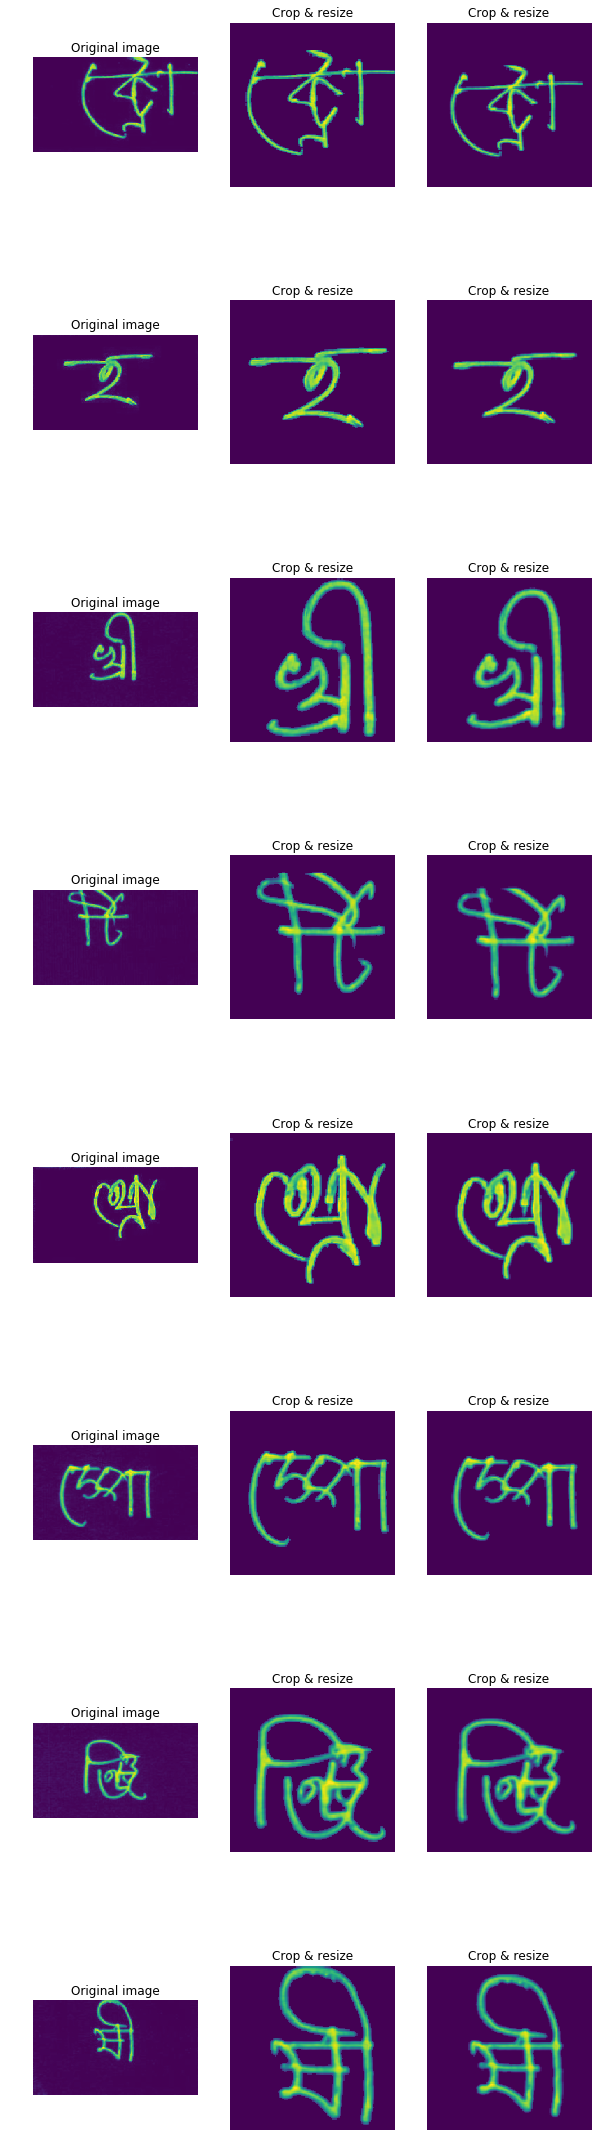

In [23]:
# df = pd.read_feather(TRAIN[0])
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 3, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img, pad=0)
    img2 = crop_resize(img, pad=16)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
    axs[idx,2].imshow(img2)
    axs[idx,2].set_title('Crop & resize')
    axs[idx,2].axis('off')
plt.show()

In [ ]:
TRAIN = [f"data/train/train_image_data_{i}.parquet" for i in range(4)]
output = "data/train_128/"
train_df = pd.read_csv('data/train.csv')

for fname in TRAIN:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            l1, l2, l3 = train_df[train_df.image_id==name].iloc[0, 1:4]
            outfname = f"{name}-{l1}-{l2}-{l3}"
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
            np.save(f'{output}{outfname}', img)


In [ ]:
TEST = [f"data/test/test_image_data_{i}.parquet" for i in range(4)]
output = "data/test_128/"

for fname in TEST:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8) #ThankGod
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
            np.save(f'{output}{name}.png', img)

In [ ]:
df